<a href="https://colab.research.google.com/github/kabirodavies/ML_classification/blob/main/kaggleclimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install gensim
# !pip install python-Levenshtein

In [2]:
# Let’s load the libraries

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Urls
url_train = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/train.csv'
url_test = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/test.csv'
url_sub = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/sample_submission.csv'


train = pd.read_csv(url_train)
train.head()


,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [4]:
test = pd.read_csv(url_test)
test.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928


In [5]:
train.shape, test.shape

((15819, 3), (10546, 2))

In [6]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(26365, 3)

In [7]:
combi.head()

,message,sentiment,tweetid
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",1.0,625221
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103
2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,2.0,698562
3,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,1.0,573736
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",1.0,466954


#Text Pre_processing

In [8]:
#Removing Twitter Handles (@user)
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [9]:
combi['message'] = np.vectorize(remove_pattern)(combi['message'], "@[\w]*") 
combi.head(10)

,message,sentiment,tweetid
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via",1.0,625221
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103
2,RT : Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,2.0,698562
3,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,1.0,573736
4,"RT : It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",1.0,466954
5,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,1.0,425577
6,RT : Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,1.0,294933
7,"RT : Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦",1.0,992717
8,"My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",1.0,664510
9,RT : no offense… but like… how do you just not believe… in global warming………,1.0,260471


In [10]:
#Data Cleaning with RegEx
def clean_text(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
  text = re.sub(r'#', '', text) # Remove '#' symbol
  text = re.sub(r':', '', text) # Remove ':' symbol
  text = re.sub(r'rt[\s]+', '', text) #Remove RT
  text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlink
  text = re.sub(r'\w*\d\w*', '', text) # Remove numbers
  return text

In [11]:
#Removing Punctuations, Numbers, and Special Characters
combi['message'] = np.vectorize(clean_text)(combi['message']) 
combi.head(10)

,message,sentiment,tweetid
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https//t.co/yeLvcEFXkC via",1.0,625221
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103
2,RT Researchers say we have three years to act on climate change before it’s too late https//t.co/ https//t.co/…,2.0,698562
3,TodayinMaker WIRED was a pivotal year in the war on climate change https//t.co/,1.0,573736
4,"RT It's , and a racist, sexist, climate change denying bigot is leading in the polls. ElectionNight",1.0,466954
5,Worth a read whether you do or don't believe in climate change https//t.co/ggLZVNYjun https//t.co/,1.0,425577
6,RT Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https//t.co/,1.0,294933
7,"RT Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https//t.co/ hÃ¢â‚¬Â¦",1.0,992717
8,"My nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",1.0,664510
9,RT no offense… but like… how do you just not believe… in global warming………,1.0,260471


In [12]:
#Removing Hyperlinks
def remove_hyperlink(word):       
    return re.sub(r"http\S+", "", word)
combi['message'] = np.vectorize(remove_hyperlink)(combi['message']) 

In [13]:
#Convert Text to lowercase characters
def to_lower(word):
  word = word.lower()
  return word
combi['message'] = np.vectorize(to_lower)(combi['message']) 

In [14]:
#Removing Short Words
combi.message = combi.message.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
combi.head(10)

,message,sentiment,tweetid
0,"polyscimajor epa chief doesn't think carbon dioxide main cause global warming and.. wait, what!? via",1.0,625221
1,it's not like lack evidence anthropogenic global warming,1.0,126103
2,researchers say have three years act climate change before it’s too late,2.0,698562
3,todayinmaker wired was pivotal year the war climate change,1.0,573736
4,"it's and racist, sexist, climate change denying bigot leading the polls. electionnight",1.0,466954
5,worth read whether you don't believe climate change,1.0,425577
6,mike pence doesn’t believe global warming that smoking causes lung cancer.,1.0,294933
7,"six big things can all today fight climate change, how climate activistã¢â‚¬â¦ hã¢â‚¬â¦",1.0,992717
8,"nephew inconsolable. wants die old age like me, but will perish the fiery hellscape climate change.",1.0,664510
9,offense… but like… how you just not believe… global warming………,1.0,260471


#Text Normalization

In [15]:
tokenized_tweet  = combi.message.apply(lambda x: x.split())
tokenized_tweet .head()

0    [polyscimajor, epa, chief, doesn't, think, carbon, dioxide, main, cause, global, warming, and.., wait,, what!?, via]
1                                                       [it's, not, like, lack, evidence, anthropogenic, global, warming]
2                                   [researchers, say, have, three, years, act, climate, change, before, it’s, too, late]
3                                                    [todayinmaker, wired, was, pivotal, year, the, war, climate, change]
4                     [it's, and, racist,, sexist,, climate, change, denying, bigot, leading, the, polls., electionnight]
Name: message, dtype: object

###stemming

In [16]:
# # Now we can normalize the tokenized text.

# from nltk.stem.porter import * 
# stemmer = PorterStemmer() 
# tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
# tokenized_tweet.head()

###Lemmatization

In [17]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [18]:
#Lematize and Join
def mbti_lemma(words, lemmatizer):       
    return " ".join([lemmatizer.lemmatize(word) for word in words])
    
tokenized_tweet = tokenized_tweet.apply(mbti_lemma, args=(lemmatizer, ))
tokenized_tweet.head

<bound method NDFrame.head of 0        polyscimajor epa chief doesn't think carbon dioxide main cause global warming and.. wait, what!? via
1                                                    it's not like lack evidence anthropogenic global warming
2                                      researcher say have three year act climate change before it’s too late
3                                                   todayinmaker wired wa pivotal year the war climate change
4                      it's and racist, sexist, climate change denying bigot leading the polls. electionnight
                                                         ...                                                 
26360          brb, writing poem about climate change. climatechange science poetry fakenews alternativefacts
26361    the year climate change came home during the hottest year record, karl mathiesen travelled tasmania…
26362              pacific country positive about fiji leading the global climate change c

In [19]:
# # Now let’s stitch these tokens back together. It can easily be done using nltk’s MosesDetokenizer function.

# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
# combi['message'] = tokenized_tweet
# combi.head(10)

In [20]:
#Split Data

#Understanding the common words used in the tweets: WordCloud

In [21]:
# Extracting train and test Word2Vec features 
train_a = combi.iloc[:15819,:]
test_a = combi.iloc[15819:,:]

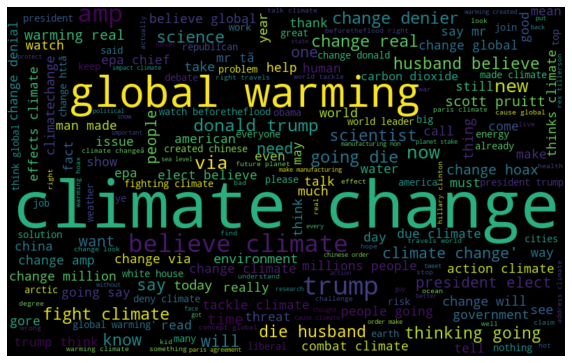

In [22]:
all_words = ' '.join([text for text in train_a['message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

##Resampling

In [23]:
from sklearn.utils import resample

In [24]:
# Separate minority and majority classes
news = train_a[train_a['sentiment']==2]
support = train_a[train_a['sentiment']==1]
neutral = train_a[train_a['sentiment']==0]
anti = train_a[train_a['sentiment']==-1]

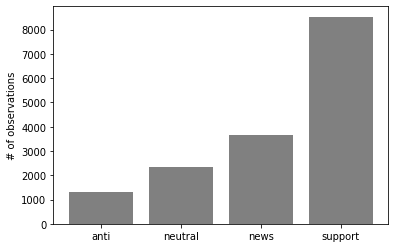

In [25]:
# Get all possible labels
labels = train_a['sentiment'].unique()
heights = [len(news),len(support), len(neutral), len(anti)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['news', 'support','neutral', 'anti'])
plt.ylabel("# of observations")
plt.show()

In [26]:
# Sentiment percentage of data before resampling.
print(f' Support: {round(len(support)/(len(train_a))*100, 2)} %')
print(f' News: {round(len(news)/(len(train_a))*100, 2)} %')
print(f' Neutral: {round(len(neutral)/(len(train_a))*100, 2)} %')
print(f' Anti: {round(len(anti)/(len(train_a))*100, 2)} %')

 Support: 53.92 %
 News: 23.01 %
 Neutral: 14.87 %
 Anti: 8.19 %


In [27]:
# Upsample minority and combine with majority
measure = int(len(support)/2)
anti_upsampled = resample(anti, replace=True, n_samples= measure, random_state=123)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(news), random_state=123)
support_downsampled = resample(support, replace=True, n_samples=len(news), random_state=123)


upsampled = pd.concat([neutral_upsampled, news, anti_upsampled, support_downsampled])

In [28]:
# Separate minority and majority classes
up_news = upsampled[upsampled['sentiment']==2]
up_support = upsampled[upsampled['sentiment']==1]
up_neutral = upsampled[upsampled['sentiment']==0]
up_anti = upsampled[upsampled['sentiment']==-1]

In [29]:
len(up_news), len(up_support), len(up_neutral), len(up_anti)

(3640, 3640, 3640, 4265)

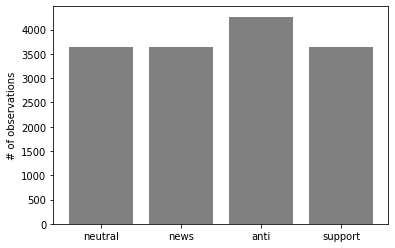

In [30]:
# Get all possible labels
labels = upsampled['sentiment'].unique()
heights = [len(up_news),len(up_support), len(up_neutral), len(up_anti)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['news', 'support','neutral', 'anti'])
plt.ylabel("# of observations")
plt.show()

#Bag-of-Words Features

In [31]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['message'])
bow.shape

(26365, 9806)

#TF-IDF Features

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['message'])
tfidf.shape

(26365, 9806)

#Word2Vec Features

###1.0 Word2Vec Embeddings

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

In [143]:
%%time
tokenized_text = combi['message'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_text,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_text, total_examples= len(combi['message']), epochs=20)


CPU times: user 2min 5s, sys: 504 ms, total: 2min 6s
Wall time: 1min 7s


In [144]:
model_w2v.wv.most_similar(positive="food")

[('production.', 0.6341868042945862),
 ('breakã¢â‚¬â¦', 0.6106792688369751),
 ('keynote', 0.5792582035064697),
 ('protein', 0.5740395188331604),
 ('supplies', 0.5688886642456055),
 ('radically', 0.5655831694602966),
 ('insecurity', 0.5640910863876343),
 ('integrated', 0.561322033405304),
 ('elitists', 0.5592528581619263),
 ('supply', 0.5556211471557617)]

In [145]:
model_w2v.most_similar(positive="trump")

[('donald', 0.5204123854637146),
 ('donaldtrump', 0.5078788995742798),
 ("trump'", 0.5005189180374146),
 ('actions.', 0.4785692095756531),
 ("fight'", 0.4719555377960205),
 ('trolls', 0.4662978947162628),
 ('newslytweet', 0.46278274059295654),
 ('chineseã¢â‚¬â¦ã¢â‚¬â¦', 0.4621478021144867),
 ('defiant', 0.461813747882843),
 ('libtard', 0.45738279819488525)]

In [146]:
model_w2v['heat']

array([ 0.3003054 , -0.3210327 ,  0.4036706 , -0.04590044,  0.45128894,
        0.17201154, -0.23952512,  0.43053898,  0.87701017,  0.5760988 ,
       -0.1956934 , -0.19221349,  0.5929922 ,  0.21826406, -0.55399007,
       -0.15892264,  0.10885897, -0.13177939,  0.05725956, -0.2688558 ,
       -0.56922174,  0.1279231 ,  0.25749776,  0.6122286 , -0.02013   ,
        0.40424135,  0.3688335 ,  0.28863192,  0.53771216,  0.75510085,
       -0.61826   ,  0.24609166,  0.45702094, -0.10130067,  0.03209697,
       -0.26257512, -0.58630943, -0.04808049,  0.01570677,  0.17804335,
        0.04668799, -0.24658287, -0.531697  , -0.30786204, -0.05100261,
       -0.15207852, -0.5932695 ,  0.07810497,  0.03867059, -0.6873259 ,
       -0.5219634 , -0.05634512, -0.5114124 ,  0.59679365,  0.59123915,
        0.29494867, -0.20417894,  0.22227176, -0.4162688 ,  0.02573966,
        0.2127063 , -0.3219327 , -0.61157054, -0.10427174,  0.59313965,
       -0.19166477, -0.25282592, -0.13231449, -0.31719935, -0.25

In [38]:
len(model_w2v['heat']) #The length of the vector is 200

1000

###Preparing Vectors for text

In [147]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [148]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(26365, 200)

##2. Doc2Vec Embedding

###More libraries

In [149]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

####To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [150]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_text = add_label(tokenized_tweet) # label all the tweets

In [151]:
labeled_text[:6]

[LabeledSentence(words="polyscimajor epa chief doesn't think carbon dioxide main cause global warming and.. wait, what!? via", tags=['tweet_0']),
 LabeledSentence(words="it's not like lack evidence anthropogenic global warming", tags=['tweet_1']),
 LabeledSentence(words='researcher say have three year act climate change before it’s too late', tags=['tweet_2']),
 LabeledSentence(words='todayinmaker wired wa pivotal year the war climate change', tags=['tweet_3']),
 LabeledSentence(words="it's and racist, sexist, climate change denying bigot leading the polls. electionnight", tags=['tweet_4']),
 LabeledSentence(words="worth read whether you don't believe climate change", tags=['tweet_5'])]

##Now let’s train a doc2vec model.

In [152]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_text)])

model_d2v.train(labeled_text, total_examples= len(train['message']), epochs=15)

100%|██████████| 26365/26365 [00:00<00:00, 1881684.33it/s]


CPU times: user 1min 28s, sys: 20.1 s, total: 1min 48s
Wall time: 1min 18s


####Preparing doc2vec Feature Set

In [153]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1, 200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(26365, 200)

In [154]:
docvec_df.shape,  wordvec_df.shape

((26365, 200), (26365, 200))

In [155]:
train.shape, test.shape

((15819, 3), (10546, 2))

In [156]:
# Extracting train and test BoW features 
train_bow = bow[:15819,:] 
test_bow = bow[15819:,:]

#Encoding

Done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:


1.   Logistic Regression
2.   Support Vector Machine
3.   RandomForest
4.   XGBoost

###Encoding Cat Var

In [49]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Transforming categorical variable to label encoded form
# train['lang_id'] = le.fit_transform(train['lang_id'])
# data['lang_id'] = le.inverse_transform(data['lang_id'])
# data['lang_id'] 

#Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

##Bag-of-Words Features

In [127]:
# Extracting train and test BoW features 
train_bow = bow[:15819,:] 
test_bow = bow[15819:,:]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(train_bow, train['sentiment'], random_state=123, test_size=0.25)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train, y_train) 

y_pred = lreg.predict(X_test) # predicting

In [128]:
pred_y = lreg.predict(X_test) #Prediction of Test set
pred_y_train = lreg.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.9220330411328388
Test Accuracy 0.718331226295828
Classification Report               precision    recall  f1-score   support

          -1       0.70      0.42      0.53       325
           0       0.54      0.45      0.49       590
           1       0.75      0.85      0.80      2137
           2       0.73      0.69      0.71       903

    accuracy                           0.72      3955
   macro avg       0.68      0.60      0.63      3955
weighted avg       0.71      0.72      0.71      3955



##TF-IDF Features


In [130]:
# Extracting train and test TF-IDF features 
train_tfidf = tfidf[:15819,:]
test_tfidf = tfidf[15819:,:] 

# splitting data into training and validation set 
tX_train, tX_test, ty_train, ty_test = train_test_split(train_tfidf, train['sentiment'], random_state=123, test_size=0.2)

td_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
td_lreg.fit(tX_train, ty_train) 

td_y_pred = td_lreg.predict(tX_test) # predicting

In [131]:
pred_y = td_lreg.predict(tX_test) #Prediction of Test set
pred_y_train = td_lreg.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

Train Accuracy 0.8248123271434216
Test Accuracy 0.7054361567635904
Classification Report               precision    recall  f1-score   support

          -1       0.82      0.28      0.41       267
           0       0.65      0.30      0.41       465
           1       0.69      0.91      0.79      1711
           2       0.76      0.64      0.69       721

    accuracy                           0.71      3164
   macro avg       0.73      0.53      0.58      3164
weighted avg       0.71      0.71      0.68      3164



##Word2Vec Features

In [157]:
# Extracting train and test Word2Vec features 
train_w2v = wordvec_df.iloc[:15819,:]
test_w2v = wordvec_df.iloc[15819:,:]

# splitting data into training and validation set 
wX_train, wX_test, wy_train, wy_test = train_test_split(train_w2v, train['sentiment'], random_state=42, test_size=0.2)

w_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
w_lreg.fit(wX_train, wy_train) 

LogisticRegression()

In [158]:
pred_y = w_lreg.predict(wX_test) #Prediction of Test set
pred_y_train = w_lreg.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



##Doc2Vec Features

In [159]:
# Extracting train and test Doc2Vec features 
train_d2v = docvec_df.iloc[:15819,:]
test_d2v = docvec_df.iloc[15819:,:]

# splitting data into training and validation set 
dX_train, dX_test, dy_train, dy_test = train_test_split(train_d2v, train['sentiment'], random_state=42, test_size=0.3)

d_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
d_lreg.fit(dX_train, dy_train) 

# predicting
d_y_pred = d_lreg.predict(dX_test) 

In [160]:
pred_y = d_lreg.predict(dX_test) #Prediction of Test set
pred_y_train = d_lreg.predict(dX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(dy_train, pred_y_train))
print('Test Accuracy', accuracy_score(dy_test, pred_y))
print('Classification Report', classification_report(dy_test, pred_y))

Train Accuracy 0.5601914566964689
Test Accuracy 0.5575221238938053
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.34      0.03      0.06       666
           1       0.58      0.89      0.70      2598
           2       0.47      0.29      0.36      1081

    accuracy                           0.56      4746
   macro avg       0.35      0.30      0.28      4746
weighted avg       0.47      0.56      0.47      4746



#2. Support Vector Machine (SVM)


In [ ]:
from sklearn import svm

###Bag-of-Words Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc.fit(X_train, y_train) 
svc_y_pred = svc.predict(X_test) # predicting

In [ ]:
#Metrics
print(accuracy_score(y_test, svc_y_pred))
print(classification_report(y_test, svc_y_pred))

0.6858407079646017
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       401
           0       0.45      0.51      0.48       666
           1       0.76      0.77      0.77      2598
           2       0.71      0.67      0.69      1081

    accuracy                           0.69      4746
   macro avg       0.61      0.60      0.61      4746
weighted avg       0.69      0.69      0.69      4746



###TF-IDF Features

In [ ]:
# training the model
t_svc = svm.SVC(kernel='linear', C=1, probability=True)
t_svc.fit(tX_train, ty_train)  
tsvc_y_pred = t_svc.predict(tX_test)

In [ ]:
#Metrics
print(accuracy_score(ty_test, svc_y_pred))
print(classification_report(ty_test, svc_y_pred))

0.6858407079646017
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       401
           0       0.45      0.51      0.48       666
           1       0.76      0.77      0.77      2598
           2       0.71      0.67      0.69      1081

    accuracy                           0.69      4746
   macro avg       0.61      0.60      0.61      4746
weighted avg       0.69      0.69      0.69      4746



###Word2Vec Features



In [ ]:
s_w_svc = svm.SVC(kernel='linear', C=1, probability=True) 

# training the model 
s_w_svc.fit(wX_train, wy_train)
s_y_pred = s_w_svc.predict(wX_test) # predicting

#Metrics
print(accuracy_score(wy_test, s_y_pred))
print(classification_report(wy_test, s_y_pred))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



###Doc2Vec Features

In [ ]:
doc_svc = svm.SVC(kernel='linear', C=1, probability=True) 

# training the model 
doc_svc.fit(dX_train, dy_train)
doc_pred = doc_svc.predict(dX_test) # predicting

#Metrics
print(accuracy_score(dy_test, doc_pred))
print(classification_report(dy_test, doc_pred))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



#Tuning

##Boosted Logistic Reg

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [ ]:
logreg_cv.fit(tX_train ,ty_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [ ]:
log_pred = logreg_cv.predict(tX_test)
#Metrics
# print(confusion_matrix(y_test, y_pred))
print(accuracy_score(ty_test, log_pred))
print(classification_report(ty_test, log_pred))
# pd.crosstab(y_test,y_pred)

0.7113358617783396
              precision    recall  f1-score   support

          -1       0.67      0.40      0.50       401
           0       0.52      0.42      0.47       666
           1       0.74      0.84      0.79      2598
           2       0.73      0.69      0.71      1081

    accuracy                           0.71      4746
   macro avg       0.67      0.59      0.62      4746
weighted avg       0.70      0.71      0.70      4746



#3.0 RandomForest

###Bag of Words

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train, y_train) 
prediction = rf.predict(X_test)

In [ ]:
#Metrics
print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.43      0.02      0.05       401
           0       0.39      0.11      0.17       666
           1       0.60      0.85      0.70      2598
           2       0.50      0.42      0.46      1081

    accuracy                           0.57      4746
   macro avg       0.48      0.35      0.34      4746
weighted avg       0.54      0.57      0.52      4746



###TF-IDF Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(tX_train, ty_train) 
prediction = rf.predict(tX_test)

In [ ]:
#Metrics
print(accuracy_score(ty_test, prediction))
print(classification_report(ty_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.43      0.02      0.05       401
           0       0.39      0.11      0.17       666
           1       0.60      0.85      0.70      2598
           2       0.50      0.42      0.46      1081

    accuracy                           0.57      4746
   macro avg       0.48      0.35      0.34      4746
weighted avg       0.54      0.57      0.52      4746



###Word2Vec Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(wX_train, wy_train) 
prediction = rf.predict(wX_test)

In [ ]:
#Metrics
print(accuracy_score(wy_test, prediction))
print(classification_report(wy_test, prediction))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



###Doc2Vec Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(dX_train, dy_train) 
prediction = rf.predict(dX_test)

In [ ]:
#Metrics
print(accuracy_score(dy_test, prediction))
print(classification_report(dy_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.75      0.01      0.01       401
           0       0.56      0.02      0.04       666
           1       0.58      0.91      0.71      2598
           2       0.53      0.32      0.40      1081

    accuracy                           0.57      4746
   macro avg       0.61      0.32      0.29      4746
weighted avg       0.58      0.57      0.49      4746



##5.XGBoost


In [57]:
from xgboost import XGBClassifier

###Bag of Words Features

In [140]:
# training the model 
b_xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
b_xgb_model.fit(X_train, y_train)


XGBClassifier(max_depth=6, n_estimators=1000, objective='multi:softprob')

In [141]:
pred_y = b_xgb_model.predict(X_test) #Prediction of Test set
pred_y_train = b_xgb_model.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.8272926500337154
Test Accuracy 0.7041719342604298
Classification Report               precision    recall  f1-score   support

          -1       0.75      0.38      0.51       325
           0       0.59      0.35      0.44       590
           1       0.71      0.88      0.78      2137
           2       0.74      0.63      0.68       903

    accuracy                           0.70      3955
   macro avg       0.70      0.56      0.60      3955
weighted avg       0.70      0.70      0.69      3955



###TF-IDF Features



In [172]:
# training the model 
tf_xgb_model = XGBClassifier(max_depth=100, n_estimators=1000)
tf_xgb_model.fit(tX_train, ty_train)

KeyboardInterrupt: ignored

In [ ]:
pred_y = tf_xgb_model.predict(tX_test) #Prediction of Test set
pred_y_train = tf_xgb_model.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

###Word2Vec Features

In [162]:
# training the model 
xgb = XGBClassifier()
xgb.fit(wX_train, wy_train) 

XGBClassifier(objective='multi:softprob')

In [163]:
pred_y = xgb.predict(wX_test) #Prediction of Test set
pred_y_train = xgb.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



###Doc2Vec Features

In [72]:
# # training the model 
# xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
# xgb_model.fit(dX_train, dy_train)
# prediction = xgb_model.predict(dX_test)

In [ ]:
#Metrics
print(accuracy_score(dy_test, prediction))
print(classification_report(dy_test, prediction))

0.7026970080067425
              precision    recall  f1-score   support

          -1       0.70      0.37      0.49       401
           0       0.58      0.38      0.46       666
           1       0.71      0.87      0.78      2598
           2       0.72      0.63      0.67      1081

    accuracy                           0.70      4746
   macro avg       0.68      0.56      0.60      4746
weighted avg       0.70      0.70      0.69      4746



#Tuning XBBOOST

In [178]:
colsample_bytree = [0.3, 0.5, 1.0]
gamma = [0.1, 1, 1.5]
learning_rate = [0.001, 0.01]
min_child_weight = [1, 5, 10]
scale_pos_weight = [1, 2, 4]
subsample = [0.8, 0.9, 1.0]
n_estimators = [50, 100, 150]
max_depth = [5, 100]

param_grid = dict(
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    learning_rate=learning_rate,
    min_child_weight=min_child_weight,
    scale_pos_weight=scale_pos_weight,
    subsample=subsample,
    n_estimators=n_estimators,
    max_depth=max_depth,
)

In [ ]:
model = XGBClassifier(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           )
best_model = grid_search.fit(X_train, y_train)
print('Optimum parameters', best_model.best_params_)

In [ ]:
tuned_model = XGBClassifier(random_state=1, 
                            colsample_bytree=0.3, 
                            gamma=1, 
                            learning_rate=0.01, 
                            max_depth=5, 
                            min_child_weight=1,
                            n_estimators=100,
                            scale_pos_weight=2, 
                            subsample=0.9)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(tuned_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC/AUC = ', scores.mean())

# 6. Multinomial Naive Bayes Classifier

####Bag of Words Features

In [165]:
# Import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
#Create MultinomialNB object
clf = MultinomialNB(alpha=0.6)
# Train clf
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.6)

In [166]:
pred_y = clf.predict(X_test) #Prediction of Test set
pred_y_train = clf.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.8331085637221848
Test Accuracy 0.7008849557522124
Classification Report               precision    recall  f1-score   support

          -1       0.61      0.44      0.51       325
           0       0.52      0.45      0.48       590
           1       0.76      0.80      0.78      2137
           2       0.68      0.73      0.71       903

    accuracy                           0.70      3955
   macro avg       0.64      0.60      0.62      3955
weighted avg       0.69      0.70      0.70      3955



###TF-IDF Features

In [168]:
tf_clf = MultinomialNB(alpha=0.6).fit(tX_train, ty_train)
# Compute Prediction
prediction = tf_clf.predict(tX_test)

In [169]:
pred_y = tf_clf.predict(tX_test) #Prediction of Test set
pred_y_train = tf_clf.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

Train Accuracy 0.7632556301856973
Test Accuracy 0.6690897597977244
Classification Report               precision    recall  f1-score   support

          -1       0.92      0.13      0.24       267
           0       0.68      0.15      0.24       465
           1       0.65      0.94      0.76      1711
           2       0.76      0.56      0.65       721

    accuracy                           0.67      3164
   macro avg       0.75      0.45      0.47      3164
weighted avg       0.70      0.67      0.62      3164



###Word2Vec Features

In [170]:
w_clf = MultinomialNB(alpha=0.6).fit(wX_train, wy_train)
# Compute Prediction
prediction = w_clf.predict(wX_test)

In [171]:
pred_y = w_clf.predict(wX_test) #Prediction of Test set
pred_y_train = w_clf.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



#To predict the test data for kaggle submission.


In [ ]:
#To predict the test data for kaggle submission.
# final_pred = xgb.predict(test_w2v)

final_pred = logreg_cv.predict(test_tfidf)


In [ ]:
#Save Model With Pickle
import pickle

model_save_path = "xgb_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(xgb,file)

In [ ]:
#Open Model With Pickle
model_load_path = "xgb_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

In [ ]:
# get predictions from unpickled model
xgb_pred = unpickled_model.predict(wX_test)

#File Submission

In [ ]:
sub = pd.read_csv(url_sub)
sub.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [ ]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['tweetid'] = test['tweetid']
submission['sentiment'] = final_pred # our model predictions on the test dataset
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [ ]:
# for Kaggle submisison
submission.to_csv('climate_change.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [ ]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("climate_change.csv")
submissions_check.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [ ]:
submission.shape

(10546, 2)

In [ ]:
from google.colab import files
files.download("climate_change.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>